## Image Scene Classification

### Downloading [dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) from Kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"Enter username","key":"Enter key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 342M/346M [00:02<00:00, 167MB/s]
100% 346M/346M [00:02<00:00, 146MB/s]


In [ ]:
!unzip '/content/intel-image-classification.zip'

### Loading the dataset

In [1]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
cls_lbls = {i:class_name for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [2]:
import numpy as np
from tqdm import tqdm
import cv2                                 
import os
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['/content/seg_train/seg_train/', '/content/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [ ]:
train_images.shape,train_labels.shape,test_images.shape,test_labels.shape,type(train_images)

((14034, 150, 150, 3), (14034,), (3000, 150, 150, 3), (3000,), numpy.ndarray)

### Exploratory Data Analysis

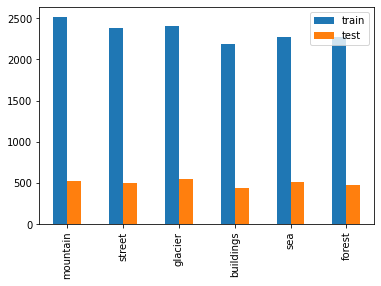

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

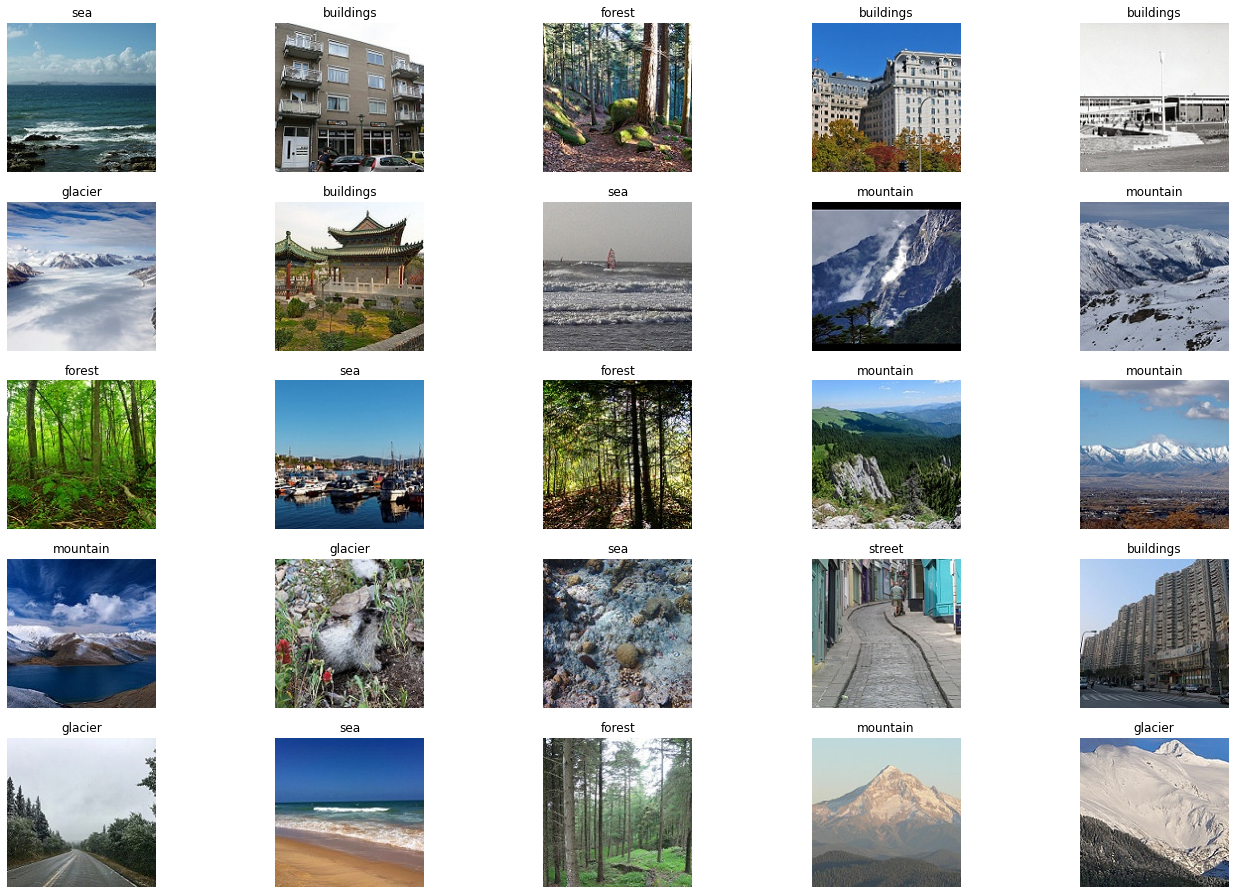

In [ ]:
import matplotlib.pyplot as plot
from random import randint


f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number].astype(np.uint8))
        ax[i,j].set_title(cls_lbls[train_labels[rnd_number]])
        ax[i,j].axis('off')

### 9 layer CNN


In [ ]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec


model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# Utils.plot_model(model,to_file='model.png',show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 180)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 180)       291780    
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 140)       226940    
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 100)       126100    
                                                        

In [ ]:
hist = model.fit(train_images,train_labels,epochs=35,validation_split=0.30)
model.save_weights('mod2_cnn_dense_softmax.h5')

In [ ]:
model.load_weights('mod2_cnn_dense_softmax.h5')

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 18s 195ms/step - loss: 5.0065 - accuracy: 0.7053


In [ ]:
preds = model.predict(test_images)
preds = np.argmax(preds,axis=1)

accuracy = accuracy_score(test_labels, preds)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_labels, preds,average='macro')
print('Precision: %f' % precision)
recall = recall_score(test_labels, preds,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(test_labels, preds,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.705333
Precision: 0.640070
Recall: 0.720092
F1 score: 0.647162


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model,layers
from tensorflow.keras.optimizers import RMSprop

pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])


In [ ]:
hist = model_vgg.fit(train_images, train_labels, batch_size=256, epochs=100, validation_split = 0.1)
model_vgg.save_weights('vgg16_dense_softmax_tf_tl.h5')

In [ ]:
model_vgg.load_weights('/content/vgg16_dense_softmax_tf_tl.h5')

In [ ]:
preds = model_vgg.predict(test_images)
preds = np.argmax(preds,axis=1)

accuracy = accuracy_score(test_labels, preds)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_labels, preds,average='macro')
print('Precision: %f' % precision)
recall = recall_score(test_labels, preds,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(test_labels, preds,average='weighted')
print('F1 score: %f' % f1)

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(test_labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=20)
plt.show()

### InceptionV3

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = "imagenet")


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

inp_model = Model(pre_trained_model.input, x) 

inp_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])
callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose = 1),
             ]

87924736/87910968 [==============================] - 1s 0us/step
last layer output shape:  (None, 7, 7, 768)


In [ ]:
history=inp_model.fit(train_images,train_labels,epochs=100,batch_size=256,validation_split = 0.1,callbacks = callbacks)
inp_model.save_weights('inceptionv3_dense_softmax_tf_tl.h5')

In [ ]:
inp_model.load_weights('/content/inceptionv3_dense_softmax_tf_tl.h5')

In [ ]:
preds = inp_model.predict(test_images)
preds = np.argmax(preds,axis=1)

accuracy = accuracy_score(test_labels, preds)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_labels, preds,average='macro')
print('Precision: %f' % precision)
recall = recall_score(test_labels, preds,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(test_labels, preds,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.912000
Precision: 0.915928
Recall: 0.913255
F1 score: 0.912136


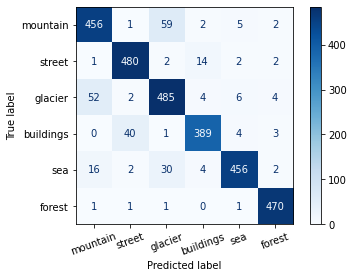

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(test_labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=20)
plt.show()

### Resnet

In [ ]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

pretrained_model=ResNet50( input_shape=(150,150,3),
                                  include_top=False,
                                  weights='imagenet'
                                   )
        
#step3        
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

#step4
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)

#step5
model_resnet = Model(pretrained_model.input, x) 

#step6
model_resnet.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose = 1),
             ]


last layer of vgg : output shape:  (None, 5, 5, 2048)


In [ ]:
history=model_resnet.fit(train_images,train_labels,epochs=100,validation_split = 0.1,callbacks = callbacks)
model_resnet.save_weights('resnet_dense_softmax_tf_tl.h5')

In [ ]:
model_resnet.load_weights('/content/resnet_dense_softmax_tf_tl.h5')

In [ ]:
test_loss = model_resnet.evaluate(test_images, test_labels)

94/94 [==============================] - 16s 171ms/step - loss: 0.6145 - acc: 0.9170


In [ ]:
preds = model_resnet.predict(test_images)
preds = np.argmax(preds,axis=1)

accuracy = accuracy_score(test_labels, preds)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_labels, preds,average='macro')
print('Precision: %f' % precision)
recall = recall_score(test_labels, preds,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(test_labels, preds,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.917000
Precision: 0.919427
Recall: 0.918913
F1 score: 0.917016


### Resnet with Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_DIR = "/content/seg_train/seg_train"


train_datagen = ImageDataGenerator( rescale = 1.0/255,
                                          validation_split=0.1,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          vertical_flip=True,
                                          fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    shuffle = True,
                                                    subset = 'training',
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

val_generator = train_datagen.flow_from_directory(train_DIR,
                                                    shuffle = True,
                                                    subset = 'validation',
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

test_DIR = "/content/seg_test/seg_test"
test_datagen = ImageDataGenerator(rescale = 1.0/255)


test_generator = test_datagen.flow_from_directory(test_DIR,
                                                  shuffle = False,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 12632 images belonging to 6 classes.
Found 1402 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,verbose = 1)

In [ ]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

#step1
pretrained_model=ResNet50( input_shape=(150,150,3),
                                  include_top=False,
                                  weights='imagenet'
                                   )
        
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

#step4
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)

#step5
resnet2 = Model(pretrained_model.input, x) 

#step6
resnet2.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

94781440/94765736 [==============================] - 1s 0us/step
last layer of vgg : output shape:  (None, 5, 5, 2048)


In [ ]:
history = resnet2.fit(train_generator,
                    epochs = 100,
                    verbose = 1,
                    validation_data = val_generator,
                   callbacks=[learning_rate_reduction,es])
resnet2.save_weights('aug2_resnet_dense_softmax_tf_tl.h5')

Epoch 1/100
99/99 [==============================] - 228s 2s/step - loss: 1.2115 - acc: 0.7997 - val_loss: 6.7700 - val_acc: 0.1526 - lr: 1.0000e-04
Epoch 2/100
99/99 [==============================] - 201s 2s/step - loss: 0.3178 - acc: 0.8970 - val_loss: 11.9109 - val_acc: 0.1890 - lr: 1.0000e-04
Epoch 3/100
99/99 [==============================] - 201s 2s/step - loss: 0.2627 - acc: 0.9151 - val_loss: 10.0023 - val_acc: 0.1947 - lr: 1.0000e-04
Epoch 4/100
99/99 [==============================] - 201s 2s/step - loss: 0.2231 - acc: 0.9270 - val_loss: 12.9222 - val_acc: 0.2040 - lr: 1.0000e-04
Epoch 5/100
99/99 [==============================] - 201s 2s/step - loss: 0.1914 - acc: 0.9358 - val_loss: 2.4268 - val_acc: 0.4686 - lr: 1.0000e-04
Epoch 6/100
99/99 [==============================] - 201s 2s/step - loss: 0.1930 - acc: 0.9407 - val_loss: 5.5317 - val_acc: 0.6098 - lr: 1.0000e-04
Epoch 7/100
99/99 [==============================] - 201s 2s/step - loss: 0.1787 - acc: 0.9451 - val_lo

In [ ]:
resnet2.load_weights('/content/aug_resnet_dense_softmax_tf_tl.h5')

In [ ]:
test_generator.reset()

preds = resnet2.predict(test_generator)
preds = np.argmax(preds,axis=1)

In [ ]:
accuracy = accuracy_score(test_generator.labels, preds)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_generator.labels, preds,average='macro')
print('Precision: %f' % precision)
recall = recall_score(test_generator.labels, preds,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(test_generator.labels, preds,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.923000
Precision: 0.925268
Recall: 0.924715
F1 score: 0.922569


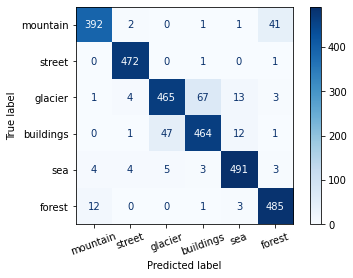

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(test_generator.labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=20)
plt.show()

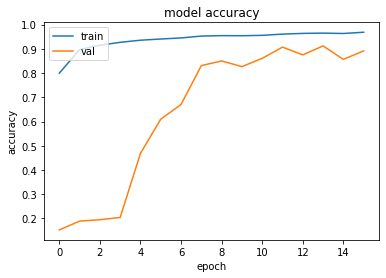

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

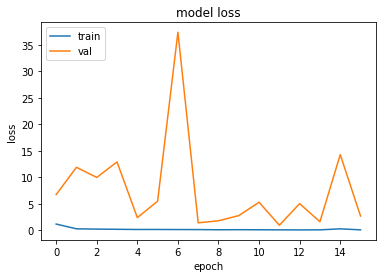

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
flag = 0
for i in test_generator.labels:
    if test_generator.labels[flag]==2 and preds[flag]==3:
        print(flag)
    flag += 1

Text(0.5, 1.0, 'Ground truth: Mountain Predicted: Forest')

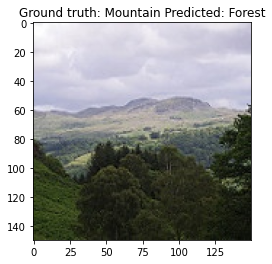

In [ ]:
idx = 1123
plt.imshow(test_images[idx].astype(np.uint8))
plt.title('Ground truth:'+class_names[test_generator.labels[idx]]+'  Predicted:'+class_names[preds[idx]])

In [ ]:
test

array([3, 3, 3, ..., 2, 2, 2], dtype=int32)